In [1]:
import tensorflow as tf
import pandas as pd
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
traindir = '../input/paddy-disease-classification/train_images/'

bacterial_leaf_blight_dir = os.path.join(traindir, 'bacterial_leaf_blight')
bacterial_leaf_streak_dir = os.path.join(traindir, 'bacterial_leaf_streak')
bacterial_panicle_blight_dir = os.path.join(traindir, 'bacterial_panicle_blight')
blast_dir = os.path.join(traindir, 'blast')
brown_spot_dir = os.path.join(traindir, 'brown_spot')
dead_heart_dir = os.path.join(traindir, 'dead_heart')
downy_mildew_dir = os.path.join(traindir, 'downy_mildew')
hispa_dir = os.path.join(traindir, 'hispa')
normal_dir = os.path.join(traindir, 'normal')
tungro_dir = os.path.join(traindir, 'tungro')


print('total bacterial_leaf_blight images:', len(os.listdir(bacterial_leaf_blight_dir)))
print('total bacterial_leaf_streak images:', len(os.listdir(bacterial_leaf_streak_dir)))
print('total bacterial_panicle_blight images:', len(os.listdir(bacterial_panicle_blight_dir)))
print('total blast images:', len(os.listdir(blast_dir)))
print('total brown_spot images:', len(os.listdir(brown_spot_dir)))
print('total dead_heart images:', len(os.listdir(dead_heart_dir)))
print('total downy_mildew images:', len(os.listdir(downy_mildew_dir)))
print('total hispa images:', len(os.listdir(hispa_dir)))
print('total normal images:', len(os.listdir(normal_dir)))
print('total tungro images:', len(os.listdir(tungro_dir)))

total bacterial_leaf_blight images: 479
total bacterial_leaf_streak images: 380
total bacterial_panicle_blight images: 337
total blast images: 1738
total brown_spot images: 965
total dead_heart images: 1442
total downy_mildew images: 620
total hispa images: 1594
total normal images: 1764
total tungro images: 1088


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmented_datagen = ImageDataGenerator(
      rescale = 1./255,
      validation_split=0.2,
      rotation_range=30,
      width_shift_range=0.02,
      height_shift_range=0.02,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
)

train_generator = augmented_datagen.flow_from_directory(
    traindir,
    subset="training",
    seed=8,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=64
)

validation_generator = augmented_datagen.flow_from_directory(
    traindir,
    subset="validation",
    seed=8,
    target_size=(224, 224), 
    class_mode='categorical',
    batch_size=64
)

Found 8330 images belonging to 10 classes.
Found 2077 images belonging to 10 classes.


In [4]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

9406464/9406464 [==============================] - 0s 0us/step


In [5]:
base_model.trainable=False

inputs = tf.keras.Input(shape=(224,224,3))

# x = preprocess_input(inputs)

x = base_model(inputs, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model2 = tf.keras.Model(inputs, outputs)

In [6]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainabl

In [7]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
model2_history = model2.fit(train_generator,
                          validation_data=validation_generator,
                          epochs=10,
                          verbose=1)

Epoch 1/10
131/131 [==============================] - 211s 2s/step - loss: 1.9617 - accuracy: 0.3205 - val_loss: 1.6600 - val_accuracy: 0.4280
Epoch 2/10
131/131 [==============================] - 146s 1s/step - loss: 1.6346 - accuracy: 0.4340 - val_loss: 1.4945 - val_accuracy: 0.4868
Epoch 3/10
131/131 [==============================] - 140s 1s/step - loss: 1.5093 - accuracy: 0.4777 - val_loss: 1.3874 - val_accuracy: 0.5311
Epoch 4/10
131/131 [==============================] - 141s 1s/step - loss: 1.4452 - accuracy: 0.5071 - val_loss: 1.3498 - val_accuracy: 0.5234
Epoch 5/10
131/131 [==============================] - 142s 1s/step - loss: 1.3840 - accuracy: 0.5252 - val_loss: 1.3095 - val_accuracy: 0.5599
Epoch 6/10
131/131 [==============================] - 141s 1s/step - loss: 1.3554 - accuracy: 0.5387 - val_loss: 1.2818 - val_accuracy: 0.5676
Epoch 7/10
131/131 [==============================] - 145s 1s/step - loss: 1.3302 - accuracy: 0.5495 - val_loss: 1.2575 - val_accuracy: 0.5739

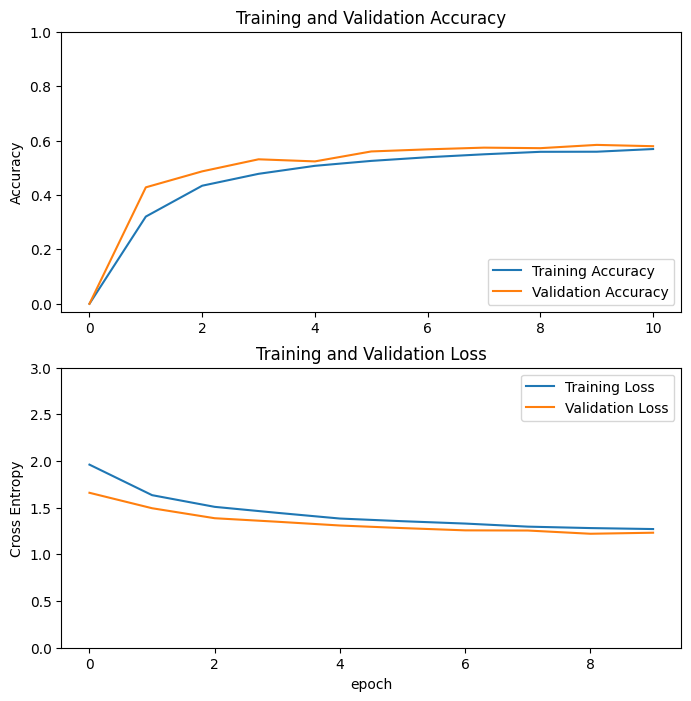

In [9]:
import matplotlib.pyplot as plt

acc = [0.] + model2_history.history['accuracy']
val_acc = [0.] + model2_history.history['val_accuracy']

loss = model2_history.history['loss']
val_loss = model2_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [10]:
base_model = model2.layers[1]
base_model.trainable = True

len(base_model.layers)

fine_tune_at = 115

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

In [11]:
model2_history2 = model2.fit(train_generator,
                             validation_data=validation_generator,
                             epochs=20,
                             verbose=1,
                             initial_epoch=model2_history.epoch[-1])

Epoch 10/20
131/131 [==============================] - 152s 1s/step - loss: 1.4656 - accuracy: 0.4980 - val_loss: 1.3293 - val_accuracy: 0.5436
Epoch 11/20
131/131 [==============================] - 142s 1s/step - loss: 1.0742 - accuracy: 0.6291 - val_loss: 0.9566 - val_accuracy: 0.6789
Epoch 12/20
131/131 [==============================] - 143s 1s/step - loss: 0.8961 - accuracy: 0.6923 - val_loss: 0.8506 - val_accuracy: 0.7102
Epoch 13/20
131/131 [==============================] - 143s 1s/step - loss: 0.7706 - accuracy: 0.7381 - val_loss: 0.8004 - val_accuracy: 0.7352
Epoch 14/20
131/131 [==============================] - 144s 1s/step - loss: 0.6992 - accuracy: 0.7617 - val_loss: 0.6971 - val_accuracy: 0.7727
Epoch 15/20
131/131 [==============================] - 159s 1s/step - loss: 0.5894 - accuracy: 0.8007 - val_loss: 0.6314 - val_accuracy: 0.7939
Epoch 16/20
131/131 [==============================] - 144s 1s/step - loss: 0.5368 - accuracy: 0.8228 - val_loss: 0.6136 - val_accuracy:

In [12]:
model2_history3 = model2.fit(train_generator,
                             validation_data=validation_generator,
                             epochs=30,
                             verbose=1,
                             initial_epoch=model2_history2.epoch[-1])

Epoch 20/30
131/131 [==============================] - 145s 1s/step - loss: 0.3436 - accuracy: 0.8834 - val_loss: 0.3958 - val_accuracy: 0.8763
Epoch 21/30
131/131 [==============================] - 142s 1s/step - loss: 0.3264 - accuracy: 0.8903 - val_loss: 0.3751 - val_accuracy: 0.8835
Epoch 22/30
131/131 [==============================] - 141s 1s/step - loss: 0.2858 - accuracy: 0.9031 - val_loss: 0.4141 - val_accuracy: 0.8729
Epoch 23/30
131/131 [==============================] - 142s 1s/step - loss: 0.2838 - accuracy: 0.9048 - val_loss: 0.3585 - val_accuracy: 0.8917
Epoch 24/30
131/131 [==============================] - 146s 1s/step - loss: 0.2466 - accuracy: 0.9167 - val_loss: 0.3468 - val_accuracy: 0.8941
Epoch 25/30
131/131 [==============================] - 145s 1s/step - loss: 0.2306 - accuracy: 0.9223 - val_loss: 0.3559 - val_accuracy: 0.8999
Epoch 26/30
131/131 [==============================] - 142s 1s/step - loss: 0.2187 - accuracy: 0.9269 - val_loss: 0.3262 - val_accuracy:

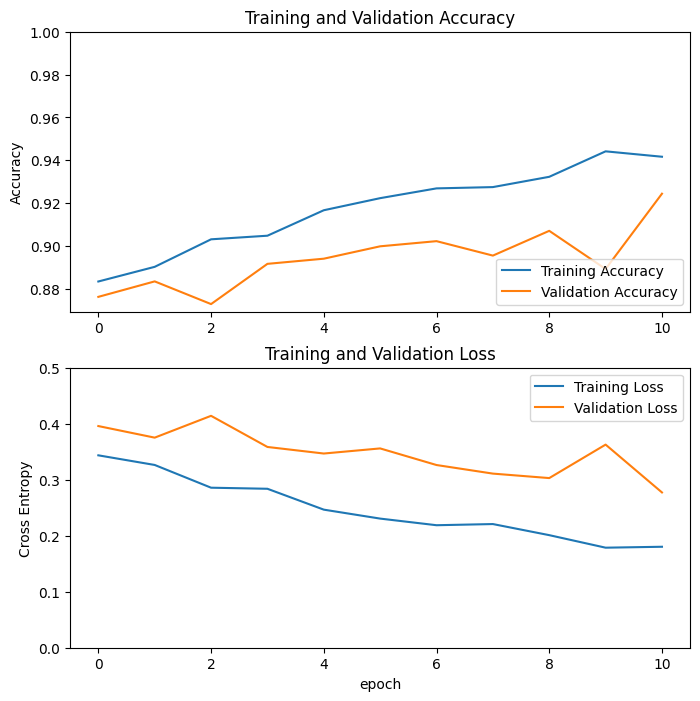

In [13]:
import matplotlib.pyplot as plt

acc = model2_history3.history['accuracy']
val_acc = model2_history3.history['val_accuracy']

loss = model2_history3.history['loss']
val_loss = model2_history3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,0.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

callback = [early_stopping, reduce_lr]

In [15]:
model2_history4 = model2.fit(train_generator,
                             epochs=50,
                             validation_data=validation_generator, 
                             verbose=1,
                             initial_epoch=model2_history3.epoch[-1],
                             callbacks=[callback])

Epoch 30/50
131/131 [==============================] - 143s 1s/step - loss: 0.1669 - accuracy: 0.9451 - val_loss: 0.2668 - val_accuracy: 0.9177 - lr: 1.0000e-04
Epoch 31/50
131/131 [==============================] - 143s 1s/step - loss: 0.1748 - accuracy: 0.9419 - val_loss: 0.3243 - val_accuracy: 0.9047 - lr: 1.0000e-04
Epoch 32/50
131/131 [==============================] - 146s 1s/step - loss: 0.1545 - accuracy: 0.9496 - val_loss: 0.2649 - val_accuracy: 0.9177 - lr: 1.0000e-04
Epoch 33/50
131/131 [==============================] - 145s 1s/step - loss: 0.1357 - accuracy: 0.9552 - val_loss: 0.2958 - val_accuracy: 0.9162 - lr: 1.0000e-04
Epoch 34/50
131/131 [==============================] - 143s 1s/step - loss: 0.1351 - accuracy: 0.9535 - val_loss: 0.2981 - val_accuracy: 0.9076 - lr: 1.0000e-04
Epoch 35/50
131/131 [==============================] - 142s 1s/step - loss: 0.1431 - accuracy: 0.9522 - val_loss: 0.2639 - val_accuracy: 0.9162 - lr: 1.0000e-04
Epoch 36/50
131/131 [=============

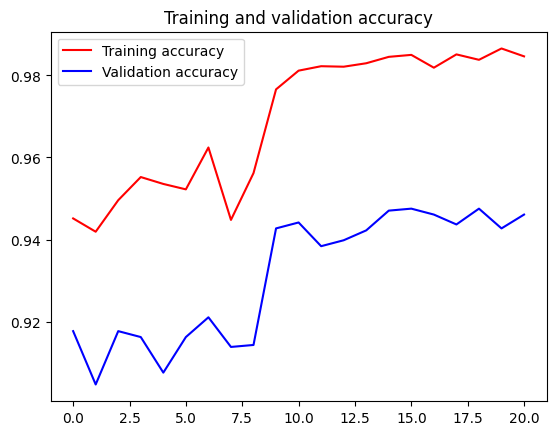

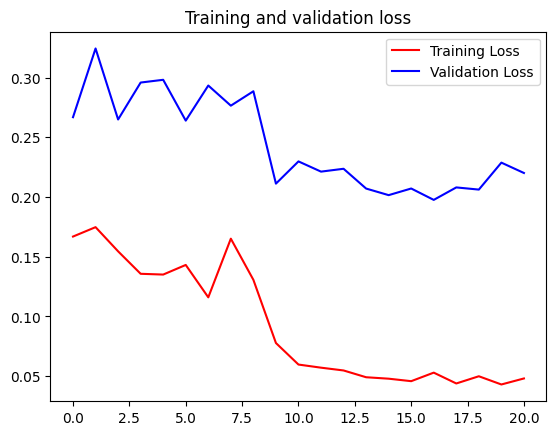

In [16]:
import matplotlib.pyplot as plt

acc = model2_history4.history['accuracy']
val_acc = model2_history4.history['val_accuracy']
loss = model2_history4.history['loss']
val_loss = model2_history4.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
sample_df=pd.read_csv('../input/paddy-disease-classification/sample_submission.csv')
labels_df=pd.read_csv('../input/paddy-disease-classification/train.csv')

In [18]:
testdir = '../input/paddy-disease-classification/test_images/'

testing = ImageDataGenerator(rescale=1.0/255).flow_from_directory(    
    directory=testdir,
    target_size=(224, 224),
    batch_size=64,
    classes=['.'],
    shuffle=False,
)

Found 3469 images belonging to 1 classes.


In [19]:
predict = tf.argmax(model2.predict(testing),axis=-1)
predict

55/55 [==============================] - 40s 716ms/step


<tf.Tensor: shape=(3469,), dtype=int64, numpy=array([7, 8, 7, ..., 8, 1, 5])>

In [20]:
diseases_types=sorted(list(set(labels_df['label'])))
n_classes=len(diseases_types)
predictions=[]
for i in predict:
    predictions.append(diseases_types[i])

In [21]:
predictions[:10]

['hispa',
 'normal',
 'hispa',
 'blast',
 'blast',
 'brown_spot',
 'dead_heart',
 'brown_spot',
 'hispa',
 'normal']

In [ ]:
#Testing the accuracy in Kaggle Submission

# sample_submission=pd.read_csv("/kaggle/input/paddy-disease-classification/sample_submission.csv").drop('label',axis=1)
# final=pd.DataFrame({'image_id': sample_submission.image_id, 'label': predictions})
# final.to_csv('submission.csv', index=None)

In [23]:
history = model2.save('scan.h5')